**Getting Data**


*   Importing Data from Yahoo Finance.
*   We are using Date and Closing Value
*   Manipulating the format to create Dataframe.

In [1]:
import pandas as pd
import datetime


#Convert String date to datetime object
def str_to_datetime(s):
    split = s.split('-')
    year,month,day = int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=year, month=month, day=day)
#read CSV
df = pd.read_csv('AAPL.csv')
#use only Date and Close Data
df = df[['Date','Close']]

#Convert all dates to datetime objects
df['Date'] = df['Date'].apply(str_to_datetime)

#Use Date as index
df.index = df.pop('Date')

In [2]:
df

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862
...,...
2022-11-28,144.220001
2022-11-29,141.169998
2022-11-30,148.029999


**Plotting Data with matplotlib**

Text(0, 0.5, 'Stock Close Price ($)')

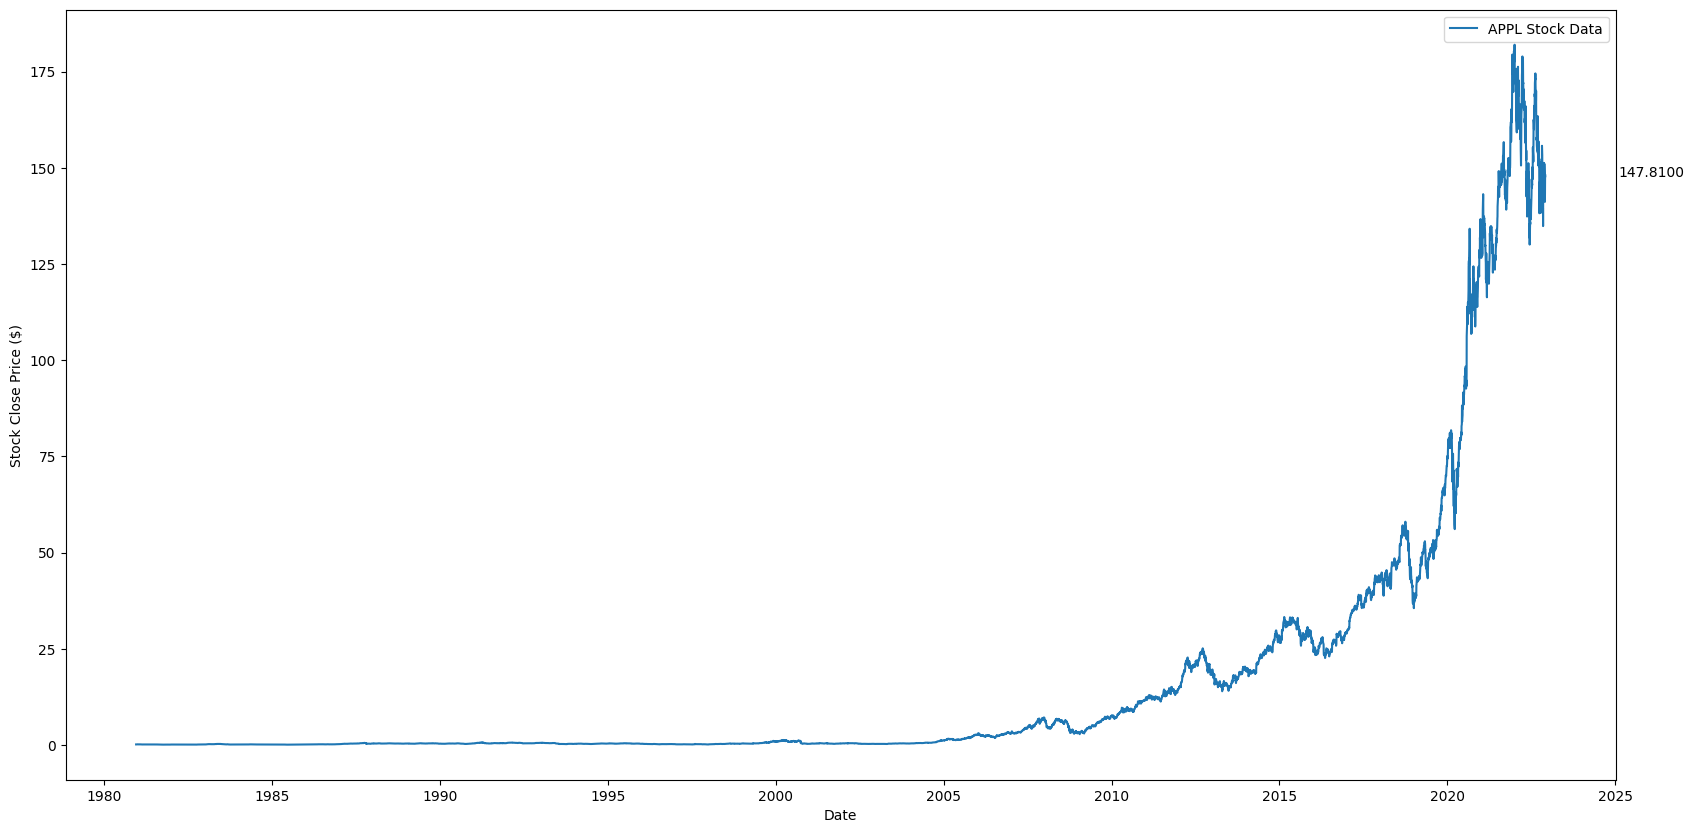

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
x = df.index
y = df['Close']
plt.plot(x, y)
plt.annotate('%0.4f' % y[-1].max(), xy=(1, y[-1].max()), xytext=(2, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.legend(['APPL Stock Data'])
plt.xlabel("Date")
plt.ylabel("Stock Close Price ($)")


**Convert to Supervised Learning Problem**

**First Time**
windowed_df = df_to_windowed_df(df, 
                                '1980-12-17', 
                                '2022-12-02', 
                                n=3)

**Second Time**
windowed_df = df_to_windowed_df(df, 
                                '2021-12-17', 
                                '2022-12-02', 
                                n=3)

**Notes**


*   n=3, using the past 3 days of data
*   Target-3, Target-2, Target-1 (past 3 days of data), input fed into model
*   Target what it actually was on that day, corresponding output





In [4]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '1980-12-17' 4th data because it depends on the previous 3
# 2nd time change date to start from to 2021-12-17
windowed_df = df_to_windowed_df(df, 
                                '2021-12-17', 
                                '2022-12-02', 
                                n=3)

#Data frame gets 3 previous values
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-12-17,174.330002,179.300003,172.259995,171.139999
1,2021-12-20,179.300003,172.259995,171.139999,169.750000
2,2021-12-21,172.259995,171.139999,169.750000,172.990005
3,2021-12-22,171.139999,169.750000,172.990005,175.639999
4,2021-12-23,169.750000,172.990005,175.639999,176.279999
...,...,...,...,...,...
237,2022-11-28,150.179993,151.070007,148.110001,144.220001
238,2022-11-29,151.070007,148.110001,144.220001,141.169998
239,2022-11-30,148.110001,144.220001,141.169998,148.029999
240,2022-12-01,144.220001,141.169998,148.029999,148.309998


**Convert to numpy arrays**


*   Feed into Tensorflow model
*   Tensorflow model is a neural network that supports one of more layers item
*   List item


*   Get dates, middle matrix, output
*   Reshape to fit LSTM model
*   List item





In [5]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  #all the rows, just the first column
  dates = df_as_np[:,0]

  #all the columns except first and last
  middle_matrix = df_as_np[:,1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:,-1]

#returning numpy arrays
  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

#3 steps in the past for 1 variable
dates.shape, X.shape, y.shape


((242,), (242, 3, 1), (242,))

**Partitioning The Data**

*   Train, train the model (sees and learns from this data) - first 80% 
*   Validation, help train the model (used to finetune model parameters) - 80%-90%
*   Testing, evaluate performance (data used to see how accurate the model is)- 90%-100%





Text(0, 0.5, 'Stock Close Price ($)')

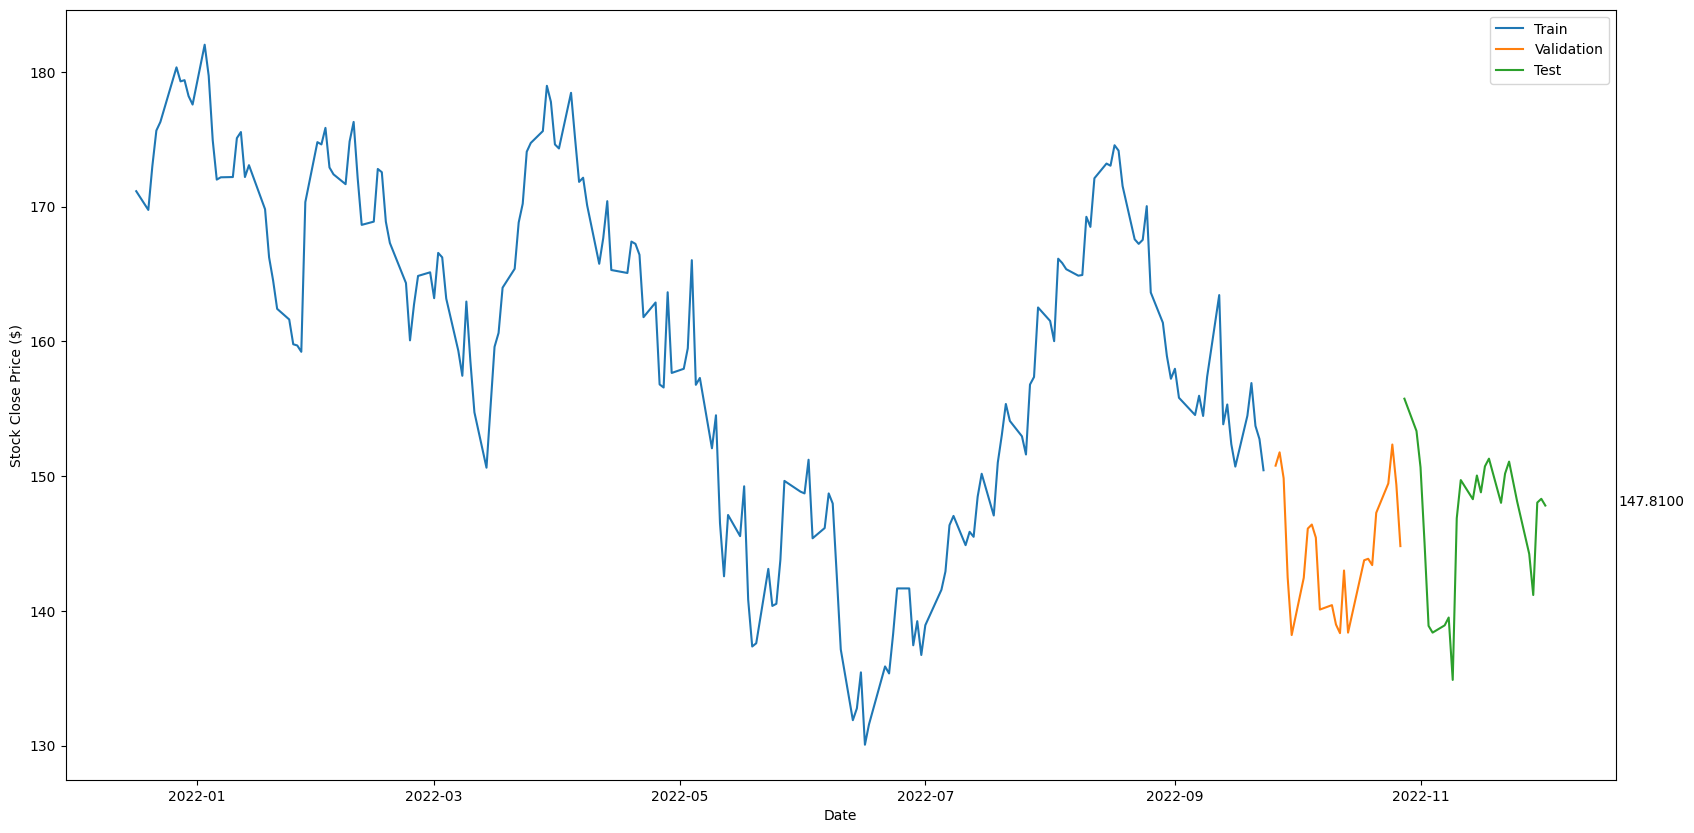

In [6]:
#Train the model
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80],X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(20,10))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.annotate('%0.4f' % y_test[-1].max(), xy=(1, y_test[-1].max()), xytext=(2, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')


plt.legend(['Train','Validation','Test'])
plt.xlabel("Date")
plt.ylabel("Stock Close Price ($)")

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3,1)), layers.LSTM(64), layers.Dense(32, activation='relu'), layers.Dense(32, activation='relu'), layers.Dense(1)])
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=100)
model.summary()

2022-12-05 20:40:50.303048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 20:40:59.228419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
7/7 [==============================] - 5s 131ms/step - loss: 25596.0664 - mean_absolute_error: 159.5042 - val_loss: 20633.4941 - val_mean_absolute_error: 143.5792
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 25380.4824 - mean_absolute_error: 158.8265 - val_loss: 20419.0059 - val_mean_absolute_error: 142.8303
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 25121.9023 - mean_absolute_error: 158.0103 - val_loss: 20152.3457 - val_mean_absolute_error: 141.8938
Epoch 4/100
7/7 [==============================] - 0s 13ms/step - loss: 24794.1016 - mean_absolute_error: 156.9696 - val_loss: 19792.8984 - val_mean_absolute_error: 140.6215
Epoch 5/100
7/7 [==============================] - 0s 13ms/step - loss: 24353.3164 - mean_absolute_error: 155.5576 - val_loss: 19318.9902 - val_mean_absolute_error: 138.9262
Epoch 6/100
7/7 [==============================] - 0s 12ms/step - loss: 23762.1426 - mean_absolute_error: 153.6422 - val_loss: 18

Orange is actual prices.
Blue is our predictions

7/7 [==============================] - 1s 3ms/step


Text(0, 0.5, 'Stock Close Price ($)')

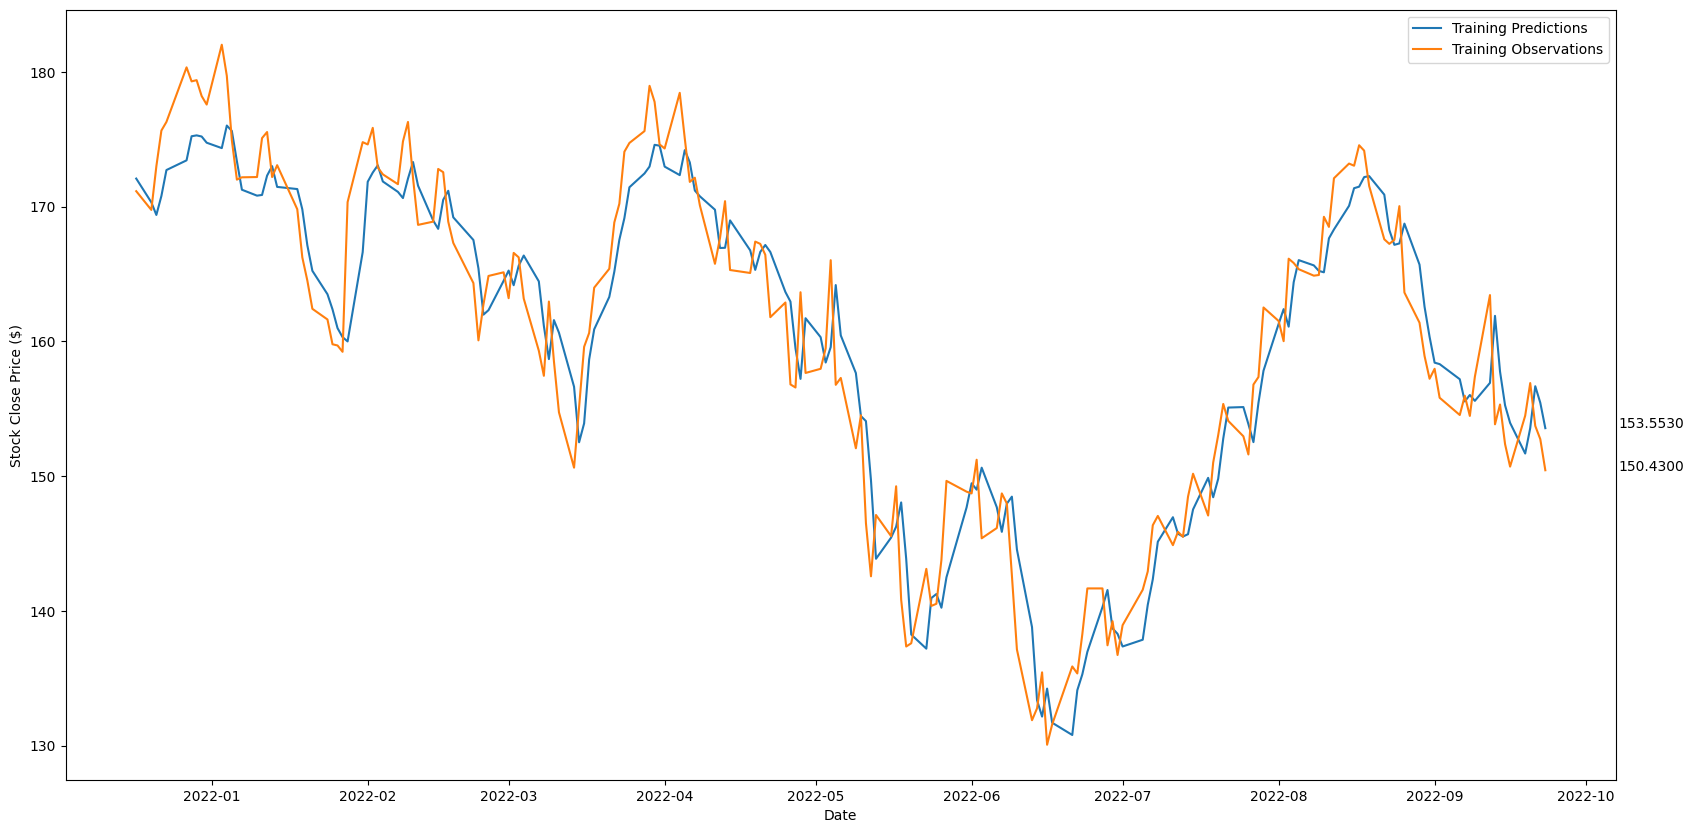

In [8]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(20,10))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.annotate('%0.4f' % train_predictions[-1].max(), xy=(1, train_predictions[-1].max()), xytext=(2, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.annotate('%0.4f' % y_train[-1].max(), xy=(1, y_train[-1].max()), xytext=(2, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')

plt.legend(['Training Predictions', 'Training Observations'])
plt.xlabel("Date")
plt.ylabel("Stock Close Price ($)")

**Zoomed in values**

1/1 [==============================] - 0s 43ms/step


Text(0, 0.5, 'Stock Close Price ($)')

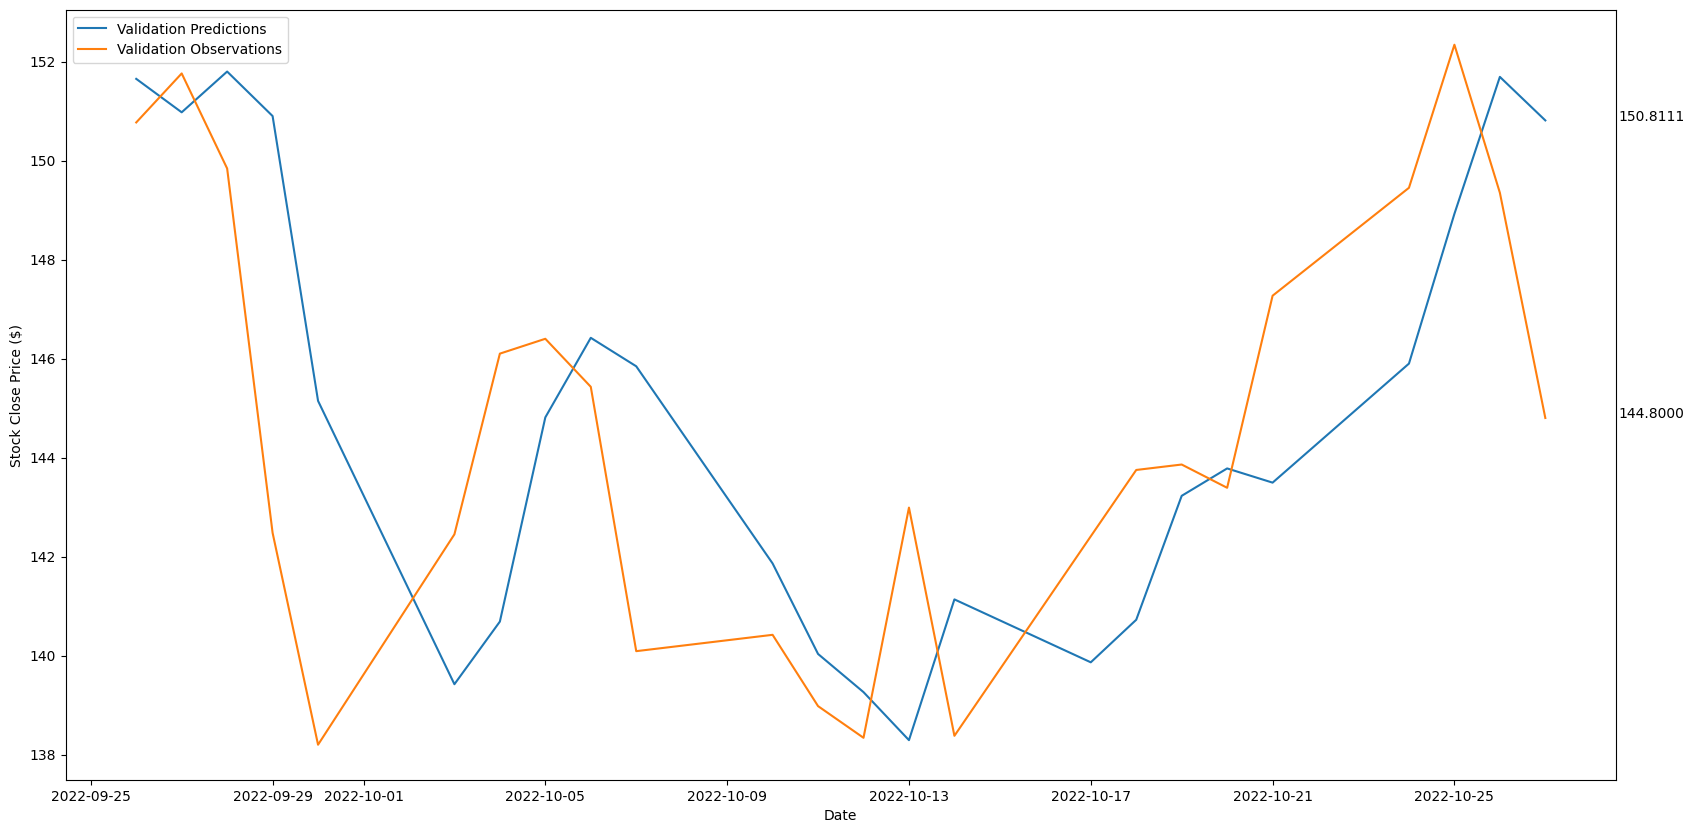

In [9]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(20,10))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)

plt.annotate('%0.4f' % y_val[-1].max(), xy=(1, y_val[-1].max()), xytext=(2, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.annotate('%0.4f' % val_predictions[-1].max(), xy=(1, val_predictions[-1].max()), xytext=(2, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.xlabel("Date")
plt.ylabel("Stock Close Price ($)")

1/1 [==============================] - 0s 30ms/step


Text(0, 0.5, 'Stock Close Price ($)')

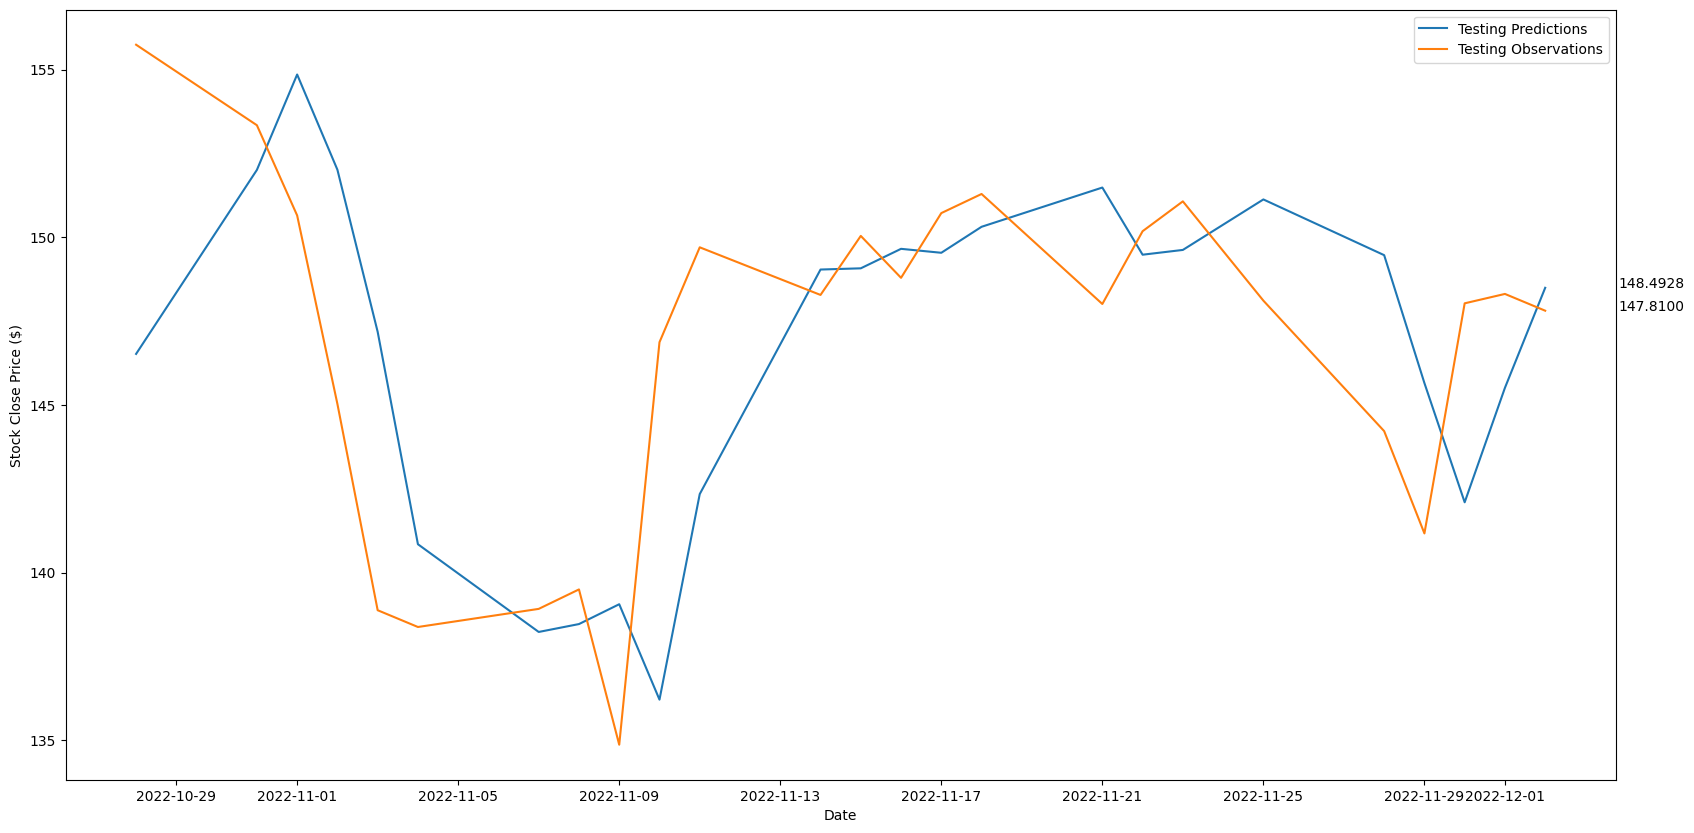

In [10]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(20,10))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.annotate('%0.4f' % test_predictions[-1].max(), xy=(1, test_predictions[-1].max()), xytext=(2, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.annotate('%0.4f' % y_test[-1].max(), xy=(1, y_test[-1].max()), xytext=(2, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')

plt.legend(['Testing Predictions', 'Testing Observations'])
plt.xlabel("Date")
plt.ylabel("Stock Close Price ($)")

Text(0, 0.5, 'Stock Close Price ($)')

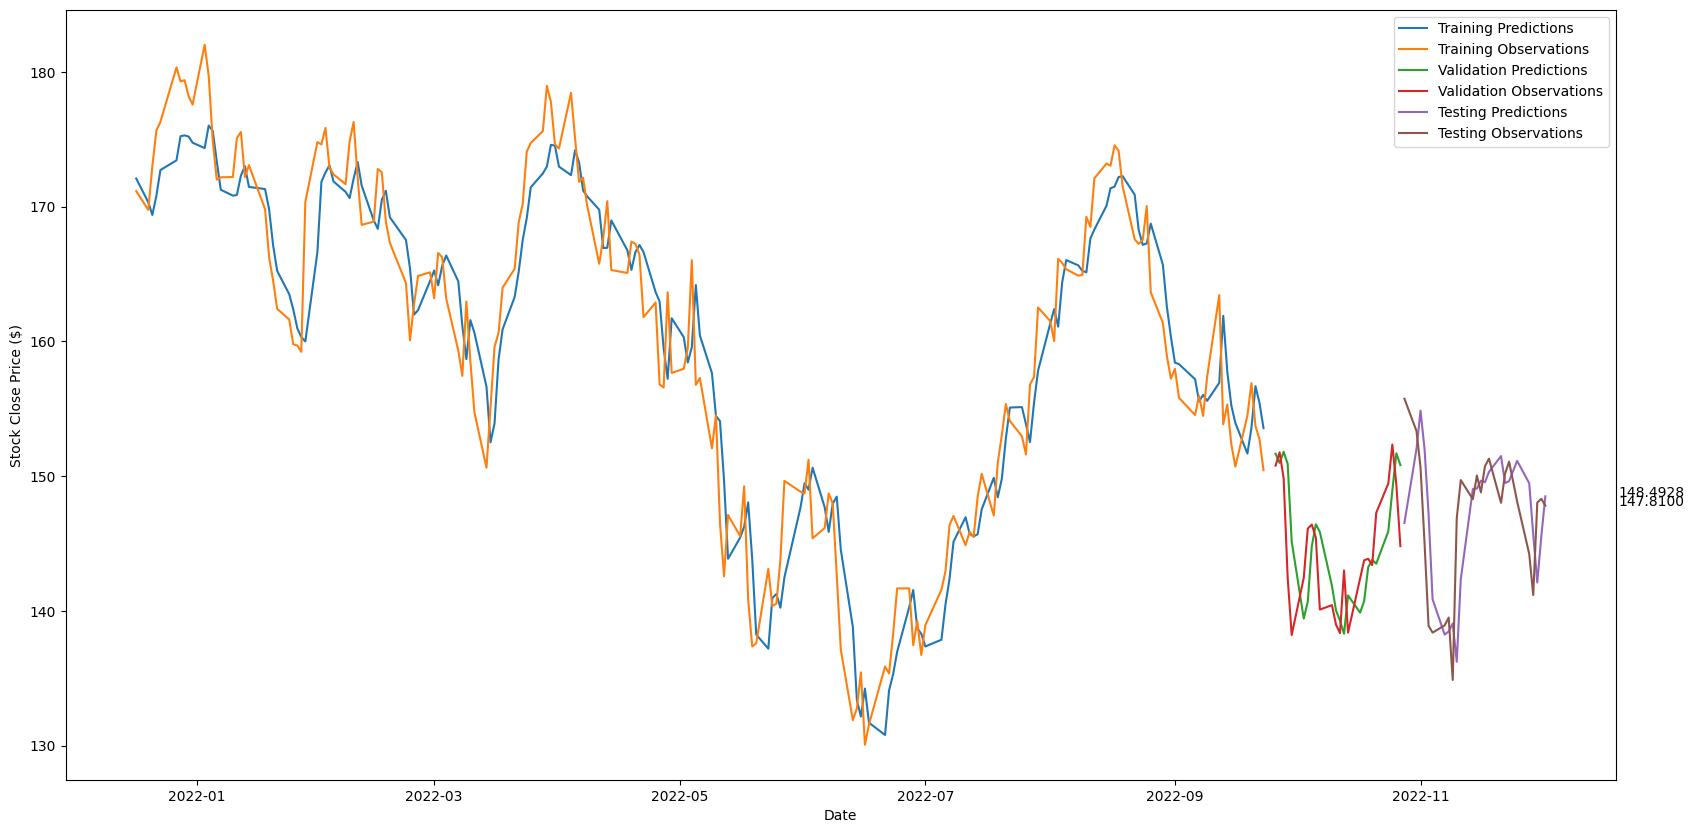

In [11]:
plt.figure(figsize=(20,10))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.annotate('%0.4f' % test_predictions[-1].max(), xy=(1, test_predictions[-1].max()), xytext=(2, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.annotate('%0.4f' % y_test[-1].max(), xy=(1, y_test[-1].max()), xytext=(2, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')

plt.legend(['Training Predictions', 'Training Observations','Validation Predictions', 'Validation Observations','Testing Predictions', 'Testing Observations'])
plt.xlabel("Date")
plt.ylabel("Stock Close Price ($)")